<a href="https://colab.research.google.com/github/hyj765/AI-study/blob/main/bert_finetune_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
import os
import re
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tqdm import tqdm
import tensorflow as tf
from transformers import TFBertModel,BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
tf.random.set_seed(111)
np.random.seed(111)

batch = 32
num = 3
valid_split = 0.2
max_len = 39

In [4]:
import urllib.request

In [5]:
train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data = train_data.dropna()
test_data = test_data.dropna()


In [6]:
tokenizer = BertTokenizer.from_pretrained('beomi/kcbert-base',cache_dir='bert_dir',do_lower_case = False)

def bert_tokenizer(sentence,MAX_LEN):
    encoded_dict = tokenizer.encode_plus(
      text = sentence,
      add_special_tokens = True,
      max_length = MAX_LEN,
      pad_to_max_length = True,
      return_attention_mask = True
    )

    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']
    return input_id,attention_mask,token_type_id

In [8]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_text, train_label in tqdm(zip(train_data['document'],train_data['label']), total=len(train_data)):

  try:
    input_id,attention_mask,token_type_id = bert_tokenizer(train_text,max_len)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    train_data_labels.append(train_label)
  except Exception as e:
    print(e)
    pass

  0%|          | 0/149995 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 149995/149995 [00:47<00:00, 3168.33it/s]


In [9]:
train_movie_inputs_ids = np.array(input_ids,dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_token_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_inputs_ids,train_movie_attention_masks,train_movie_token_type_ids)
train_data_labels = np.asarray(train_data_labels,dtype=np.int32)


In [10]:

in_put = train_movie_inputs_ids[0]
am = train_movie_attention_masks[0]
ti = train_movie_token_type_ids[0]

print(in_put)
print(am)
print(ti)
print(tokenizer.decode(in_put))

[    2  2170   832  5045    17    17  7992 29734  4040 10720     3     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [15]:
class TFBertClassicfier(tf.keras.Model):
  def __init__(self,model_name,dir_path,num_classes):
    super(TFBertClassicfier,self).__init__()
    self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path,from_pt=True)
    self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
    self.classifier = tf.keras.layers.Dense(num_classes,
                                            kernel_initializer = tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                            name='classifier')
  def call(self,input,attention=None,token_type_ids=None,training = False):
      outputs = self.bert(input,attention_mask=attention, token_type_ids=token_type_ids)
      pooled_output = outputs[1]
      pooled_output = self.dropout(pooled_output,training=training)
      logits = self.classifier(pooled_output)

      return logits

model = TFBertClassicfier('beomi/kcbert-base',dir_path='bert_ckpt',num_classes=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [16]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer,loss=loss,metrics=[metric])

In [ ]:
os.makedirs()

In [17]:
model_name = "tf2_bert_naver_movie"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
checkpoint_path = os.path.join('./',model_name,'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)



In [18]:
os.makedirs(checkpoint_dir,exist_ok=True)

In [19]:
cp_callback = ModelCheckpoint(checkpoint_path,monitor='val_accuracy',
                              verbose=1,save_best_only=True,save_weights_only =True)

In [21]:
history = model.fit(train_movie_inputs,train_data_labels,epochs=num,batch_size=batch, validation_split=0.2,
                    callbacks=[earlystop_callback,cp_callback])

print(history.history)

Epoch 1/3
3750/3750 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8630
Epoch 1: val_accuracy improved from -inf to 0.89400, saving model to ./tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 1125s 293ms/step - loss: 0.3161 - accuracy: 0.8630 - val_loss: 0.2552 - val_accuracy: 0.8940
Epoch 2/3
3750/3750 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9163
Epoch 2: val_accuracy did not improve from 0.89400
3750/3750 [==============================] - 1102s 294ms/step - loss: 0.2112 - accuracy: 0.9163 - val_loss: 0.2645 - val_accuracy: 0.8902
Epoch 3/3
3750/3750 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9494
Epoch 3: val_accuracy did not improve from 0.89400
3750/3750 [==============================] - 1099s 293ms/step - loss: 0.1345 - accuracy: 0.9494 - val_loss: 0.2943 - val_accuracy: 0.8897
{'loss': [0.31608909368515015, 0.21123400330543518, 0.13447606563568115], 'accuracy': [0.8

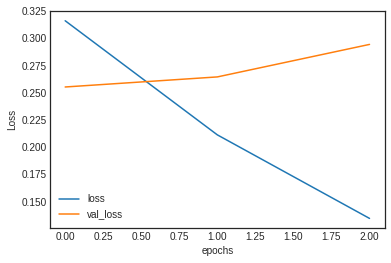

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'])
plt.show()

In [23]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_text, test_label in tqdm(zip(test_data['document'],test_data['label'])):

  try:
    input_id,attention_mask,token_type_id = bert_tokenizer(train_text,max_len)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    test_data_labels.append(train_label)
  except Exception as e:
    print(e)
    pass

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
49997it [00:15, 3324.59it/s]


In [24]:
test_movie_inputs_ids = np.array(input_ids,dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_token_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_inputs_ids,test_movie_attention_masks,test_movie_token_type_ids)
test_data_labels = np.asarray(test_data_labels,dtype=np.int32)


In [25]:
model.evaluate(test_movie_inputs,test_data_labels, batch_size= 1024)

49/49 [==============================] - 119s 2s/step - loss: 0.4949 - accuracy: 1.0000


[0.494886577129364, 1.0]